In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version= 1, as_frame= False)
mnist.keys()

c:\Users\anhdo\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**70,000 images and each image has 784 features because each image is 28 x 28 pixels, and each feature represents one pixel's intensity, from 0 (white) to 255 (black)**

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

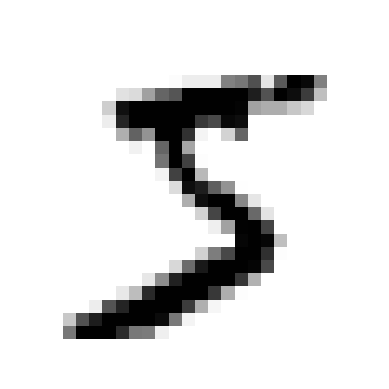

In [5]:


some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= mpl.cm.binary) # type: ignore
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
# Cast y to integers
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

**The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)**

**The training set is already shuffled for us -> guarantees that all cross-validation folds will be similar**

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Training a Binary Classifier** <br/>
Identify one digit (5) and distinguish between 5 and not-5

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [10]:
# Train it on the whole training set
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state= 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

**Performance Measures**

Measuring accuracy using cross-validation

**Note**: StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle= True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring= "accuracy")

array([0.91125, 0.90855, 0.90915])

**Consfusion Matrix**: better way to evaluate the performance of a classifier
Count number of times instances of class A are classified as class B -> know the number of times the classifier confused images of 5s with 3s -> look in 5th row and 3rd column of confusion matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

53,892 were correctly classified as 5s (true positives) <br/>
687 were wrongly classified as 5s (false positives) <br/>
1,189 were wrongly classified as non-5s (false negatives) <br/>
3,232 were correctly classified as non-5s (true negatives) <br/>

In [16]:
# pretend we reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

precision = TP / (TP + FP) <br/>
recall = TP / (TP + FN) <br/>

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Combine precision and recall into a single metric called the F1 score <br/>
F1 score is the harmonic mean of precision and recall <br/>
F1=2/(1/precision+1/recall)=TP/(TP+(FN+FP)/2) <br/>

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Increasing precision reduces recall, and vice versa -> called precision/recall tradeoff

a decision function if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class 

raise threshold -> precision goes up (less false positives) but recall goes down (more false negatives) 

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method= "decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


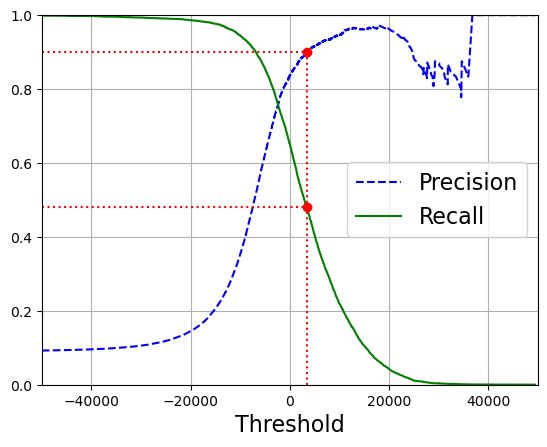

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # first value where precision >= 0.90
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # first value where precision >= 0.90

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")    
plt.show()

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [27]:
recall_score(y_train_5, y_train_pred_90) # A high precision classifier is not very useful if its recall is too low

0.4799852425751706

**The ROC Curve** (The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers) <br/>

plots the true positive rate (another name for recall) against the false positive rate (FPR). <br/>

TNR is also called `specificity`. Hence the ROC curve plots sensitivity (recall) versus `1 – specificity`. <br/>

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

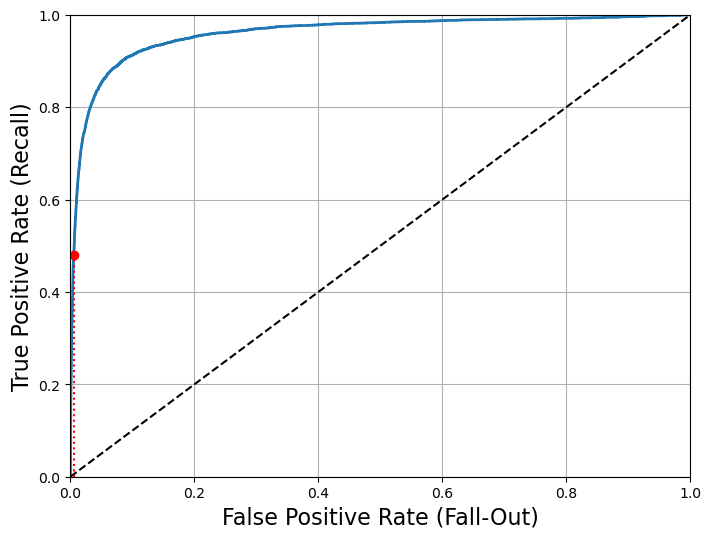

In [29]:
def plot_roc_curve(fpr, tpr, label= None):
    plt.plot(fpr, tpr, linewidth= 2, label = label)
    plt.plot([0, 1], [0, 1],'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)    


plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

A good clasifier stays as far away from the dotted line (ROC curve) as possible (toward the top-left corner) <br/>

One way to compare classifiers is to measure the `area under the curve` (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. <br/>

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier class does not have a decision_function() method. Instead it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5)

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [32]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

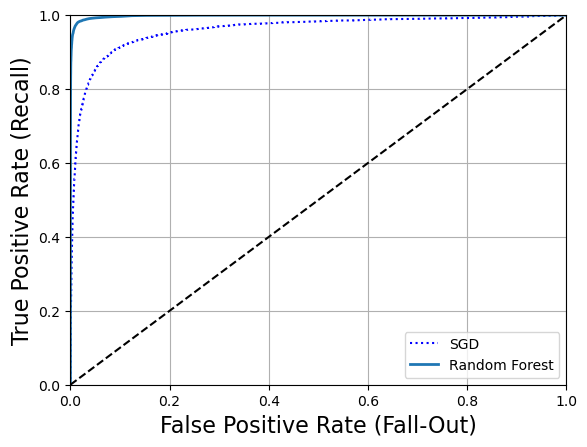

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [36]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

**Multiclass Classification** can distinguish between more than two classes <br/>
`Random Forest classifiers` or `naive Bayes classifiers` can handle multiple classes directly. <br/>
`SVM classifiers` or `Linear classifiers` are strictly binary classifiers. <br/>
one-verus-all (OvA) strategy: train 10 binary classifiers, get their decision scores for the image, and select the class whose classifier outputs the highest score. <br/>
one-verus-one (OvO) strategy: train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. If there are N classes, you need to train N × (N – 1) / 2 classifiers. <br/>

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [38]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
np.argmax(some_digit_scores)

3

In [40]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
len(ovo_clf.estimators_)

45

In [43]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled,y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**Error Analysis**

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

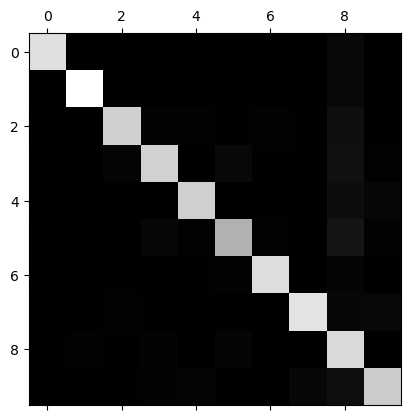

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [49]:
row_nums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_nums

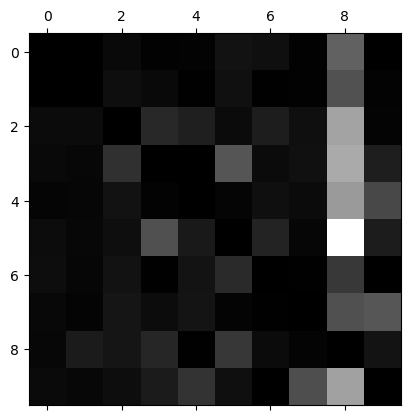

In [50]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

**Multilabel Classification**

In [52]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [53]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


0.976410265560605

`Multioutput classification`: generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values). <br/>

In [57]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


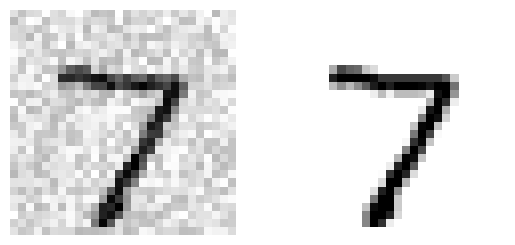

In [58]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()
